# Présence du monde académique dans les projets Open Source de Machine Learning : ces projets sont-ils faits par des chercheurs ?

Dans le cadre de nos recherches, nous nous interrogeons sur la participation du monde académique au sein des projets Open Source de Machine Learning.

Nos hypothèses sur la question sont les suivantes :
* Les contributions viennent majoritairement de contributeurs académiques (en nombre de *commits* et en nombre de lignes).
* Les contributeurs académiques sont les contributeurs qui contribuent le plus individuellement (en nombre de *commits* et en nombre de lignes).
* La majorité des *commits* ajoutant des fonctionnalités proviennent de contributeurs académiques.

Les hypothèses de travail que nous posons concernent la bonne foi des contributeurs dans les informations de *commit*. En particulier :
* Le nom/prénom est celui de l'auteur.
* L'adresse mail appartient à l'auteur. Le domaine de l'adresse est celui d'une académie si il est contributeur académique ou d'une entreprise si le contributeur contribue dans le cadre de son travail en entreprise.

Pour étudier ces hypothèses et tenter de les réfuter, nous allons nous pencher sur les contributions de trois projets :
* [Scikit-Learn](http://scikit-learn.org/stable/) ([dépôt GitHub](https://github.com/scikit-learn/scikit-learn)).
* [Keras](https://keras.io/) ([dépôt GitHub](https://github.com/keras-team/keras)).
* [Theano](http://deeplearning.net/software/theano/) ([dépôt GitHub](https://github.com/Theano/Theano)).

Les données que nous allons exploiter dans ce document sont issues d'une extraction depuis leur dépôt Git respectif grâce à Repodriller. L'étude est reproductible avec le code disponible sur [notre dépôt GitHub](https://github.com/AntoineAube/reace-study).

In [1]:
# Let us import some awesome libraries!
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Just a bit of style. ;)
sns.set_palette(sns.color_palette('hls', 8))

In [2]:
# Let us load the datasets.
scikit_dataset = pd.read_csv('study-results/scikit-learn/exploration.csv')
keras_dataset = pd.read_csv('study-results/keras/exploration.csv')
theano_dataset = pd.read_csv('study-results/theano/exploration.csv')

# For example, let us take a look to the Scikit-Learn dataset.
scikit_dataset.sample(10)

,COMMIT_HASH,AUTHOR_NAME,AUTHOR_EMAIL,MODIFICATIONS_COUNT,TIMESTAMP,ADDED_LINES,DELETED_LINES,DELETED_FILES
12853,9e44e3a62df73b4f812409ae5f6af644ceda222a,Robert McGibbon,rmcgibbo@gmail.com,1,1363123404000,1,1,0
9398,ad66a25f5a4c76be1f7690190d968fd25543290c,Subhodeep Moitra,subhodeep.moitra@gmail.com,1,1331677573000,7,1,0
17636,3edfa3cf17667011ce74afd87879566b995f7802,MechCoder,manojkumarsivaraj334@gmail.com,11,1406649870000,42,33,0
22112,fa8fe859c4c418a503cfd14d5672c9188f4cf332,Alexandre Gramfort,alexandre.gramfort@m4x.org,2,1471699153000,4,4,0
6531,0240e194e97cb64225a6f69f65ffc71340ac48f6,vene,vlad@vene.ro,2,1319124985000,2,3,0
4177,80da99a483b774f0ad08afb19883bc658a20d9be,Lars Buitinck,L.J.Buitinck@uva.nl,1,1305911864000,6,11,0
10958,711fb9606f75af9bc372cbc5ff15d390a469f49f,John Benediktsson,mrjbq7@gmail.com,1,1351018724000,4,4,0
13083,ddaa494c116e3c16bf032003c5cccbed851733d2,Lars Buitinck,larsmans@gmail.com,1,1367408230000,68,79,0
4462,5fd648c427a0efa413d35731eb13f20f10047106,vene,vlad@vene.ro,3,1307993487000,59,2,0
22428,3fbfb1bf5e24c826209fa5a5c080140a7abdac63,Jonathan Rahn,rahn.jonathan@gmail.com,1,1475525929000,1,1,0


## Quels sont les contributeurs académiques ?

Pour répondre à cette question, nous allons classifier les contributeurs à l'aide de leur adresse mail (information suffisante d'après nos hypothèses de travail).

D'autres options ont été envisagées :
* Rechercher le nom du contributeur sur un moteur de recherche de publications scientifiques. Au point où nous sommes de nos recherches, les sites trouvés sont soit très incomplets (arXiv.org), soit spécifiques à d'autres domaines (notamment le médical), soit ils ne proposent pas d'API (ResearchGate).
* Rechercher au cas par cas. Cette solution serait fastidieuse car les projets étudiés comptent un grand nombre de contributeurs.

Dans la méthode choisie, nous étudions le domaine de l'adresse mail en procédant itérativement pour chaque dépôt étudié :
* Pour les contributions qui n'ont pas été marquées "académique" à l'étape précédente, nous extrayons le domaine.
* Nous listons ces domaines et les observons un à un (éventuellement, nous cherchons sur Internet). Nous l'ajoutons à notre liste blanche si elle correspond à un laboratoire de recherche ou à un chercheur en particulier.

Cette méthode est fastidieuse mais permet de coller au mieux à notre hypothèse de travail. Comme elle est essentiellement manuelle, elle est sensible aux erreurs humaines...

In [3]:
def address_domain(address):
    split = address.split('@')
    
    if len(split) == 2:
        return split[1]
    else:
        return address
    
academic_domains = ['inria.fr', 'cnes.fr', 'normalesup.org', 'ensta.org', 'jnphilipp.org',
                    'vene.ro', 'cern.ch', 'uva.nl', 'cea.fr', 'heig-vd.ch', 'wxs.ca', 'smerity.com',
                    'nsup.org', 'esciencecenter.nl', 'centraliens.net', 'acm.org', 'fu-berlin.de', 
                    'fit.vutbr.cz', 'hec.ca', 'barvinograd.com', 'jakelee.net', 'maluuba.com',
                    'nicta.com.au', 'poli.ufrj.br', 'barkalov.ru', 'allenai.org', 'usherbrooke.ca',
                    'taehoonlee.com', 'bioinf.jku.at', 'nerdluecht.de', 'yosinski.com', 'tum.de',
                    'enlnt.com', 'kottalam.net', 'jan-schlueter.de', 'iupr.com', 'uoguelph.ca',
                    'marcodena.it', 'esimon.eu', 'stophr.be', 'jan-matthis.de', 'josephpcohen.com',
                    'cwi.nl']
academic_domains_ends = ['edu', 'ens-cachan.fr', 'intra.cea.fr', 'ntnu.no', 'umontreal.ca', 'mcgill.ca', 'epita.fr']
academic_domains_contents = ['.ca.', 'research', '.ac.', '.uu.', 'edu', 'student', 'uni', 'etu']

def is_academic_address(domain):
    for end in academic_domains_ends:
        if domain.endswith(end):
            return True
    
    for content in academic_domains_contents:
        if content in domain:
            return True
        
    return domain in academic_domains

def add_is_academic(df):
    df['IS_ACADEMIC'] = df['AUTHOR_EMAIL'].apply(address_domain).apply(is_academic_address)

## Enrichissons les données

Pour pouvoir répondre aux questions suivantes, il va nous falloir enrichir les sets de données que nous avons chargé.

Nous allons ajouter les champs suivants :
* **PROJECT** : le nom du projet (utile pour fusionner les sets de données pour comparaison).
* **IS_ACADEMIC** : la contribution est-elle présumée venir d'un contributeur académique ?

In [4]:
# Add PROJECT.
scikit_dataset['PROJECT'] = 'Scikit-Learn'
keras_dataset['PROJECT'] = 'Keras'
theano_dataset['PROJECT'] = 'Theano'

In [5]:
# Add IS_ACADEMIC.
add_is_academic(scikit_dataset)
add_is_academic(keras_dataset)
add_is_academic(theano_dataset)

Nous créons un set de données collectant les données pour tous les projets étudiés.

In [6]:
all_datasets = pd.concat([scikit_dataset, keras_dataset, theano_dataset])

In [7]:
# For example, let us take a look to the Scikit-Learn dataset after the change.
all_datasets.sample(5)

,COMMIT_HASH,AUTHOR_NAME,AUTHOR_EMAIL,MODIFICATIONS_COUNT,TIMESTAMP,ADDED_LINES,DELETED_LINES,DELETED_FILES,PROJECT,IS_ACADEMIC
23135,6b8d3f0dad12b43e83167bb56220f04f689a9dea,Francesco Visin,fvisin@gmail.com,1,1468422510000,1,1,0,Theano,False
890,dbdcade4f0e46cfe5bef26e9880bbfad9fac75d5,James Bergstra,bergstrj@iro.umontreal.ca,1,1225150751000,24,0,0,Theano,True
1732,27351bf2b1f35add223b227f68e17decd624265d,Frederic Bastien,bastienf@iro.umontreal.ca,1,1244061255000,18,1,0,Theano,True
1953,ad942afad24c7a8ff8ec7dac7da89e1fcd71f635,James Bergstra,bergstrj@iro.umontreal.ca,1,1250704655000,1,1,0,Theano,True
11622,11603832b17c89bfeba96acc10ac14b7b582feec,abalkin,abalkin@enlnt.com,2,1355012288000,28,6,0,Theano,True


## Les contributions viennent-elles majoritairement de contributeurs académiques ?

### En nombre de *commits* par contributeur

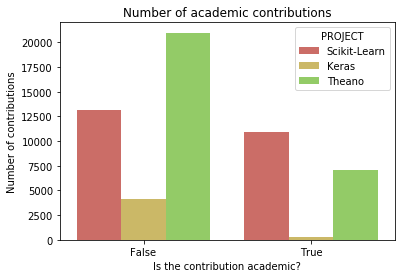

In [8]:
sns.countplot('IS_ACADEMIC', hue = 'PROJECT', data = all_datasets)

plt.title('Number of academic contributions')
plt.xlabel('Is the contribution academic?')
plt.ylabel('Number of contributions');

# TODO Show the bars in frequencies.

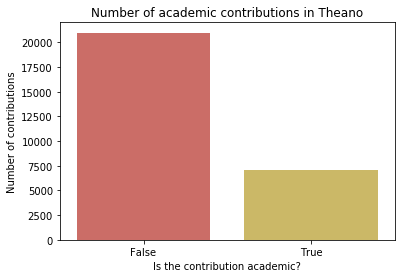

In [9]:
sns.countplot('IS_ACADEMIC', data = theano_dataset)

plt.title('Number of academic contributions in Theano')
plt.xlabel('Is the contribution academic?')
plt.ylabel('Number of contributions');

### En nombre de fichiers modifiés par *commit*

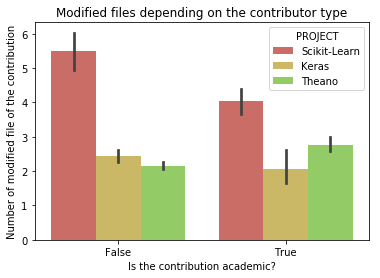

In [9]:
sns.barplot(x = 'IS_ACADEMIC', y = 'MODIFICATIONS_COUNT', hue = 'PROJECT', data = all_datasets)

plt.title('Modified files depending on the contributor type')
plt.xlabel('Is the contribution academic?')
plt.ylabel('Number of modified file in the contribution');

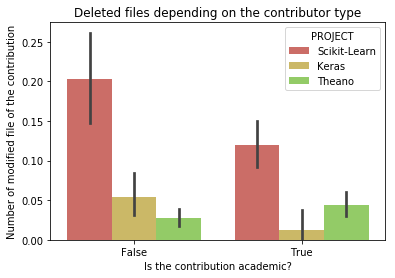

In [15]:
sns.barplot(x = 'IS_ACADEMIC', y = 'DELETED_FILES', hue = 'PROJECT', data = all_datasets)

plt.title('Deleted files depending on the contributor type')
plt.xlabel('Is the contribution academic?')
plt.ylabel('Number of deleted file in the contribution');

### En nombre de lignes ajoutées/retirées par *commit*

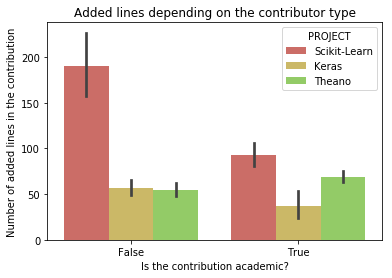

In [13]:
sns.barplot(x = 'IS_ACADEMIC', y = 'ADDED_LINES', hue = 'PROJECT', data = all_datasets)

plt.title('Added lines depending on the contributor type')
plt.xlabel('Is the contribution academic?')
plt.ylabel('Number of added lines in the contribution');

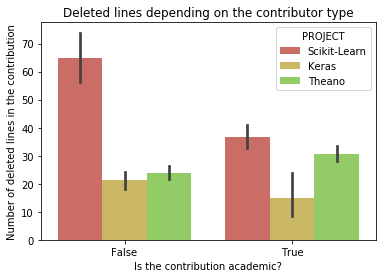

In [14]:
sns.barplot(x = 'IS_ACADEMIC', y = 'DELETED_LINES', hue = 'PROJECT', data = all_datasets)

plt.title('Deleted lines depending on the contributor type')
plt.xlabel('Is the contribution academic?')
plt.ylabel('Number of deleted lines in the contribution');